In [1]:
import numpy as np
import sys
import copy
import corner 
print(sys.executable)
import os
import scarlet
print(scarlet.__file__)
import astropy.io.fits as fits
from astropy.wcs import WCS
from scarlet.display import AsinhMapping,AsinhPercentileNorm,LinearPercentileNorm
import glob
import sep
import tarfile
import matplotlib
import matplotlib.pyplot as plt
import numpyro.distributions as dist
import astropy.units as u
from astropy.coordinates import SkyCoord
from astropy.time import Time
from astropy.wcs import WCS
import jax.numpy as jnp
import equinox as eqx
from jax import random, jit
import distrax
import optax
from tqdm.auto import tqdm
import pandas as pd
from numpyro.distributions import constraints
import cmasher as cmr
from scarlet2 import *
import scarlet2
from scarlet2 import relative_step
print(scarlet2.__file__)
# use a better colormap and don't interpolate the pixels
matplotlib.rc('image', cmap='gray', interpolation='none', origin='lower')
from matplotlib.patches import Ellipse
from scipy.stats import gaussian_kde as kde
from scipy.stats import norm
from functools import partial
from skimage import draw
%matplotlib inline
import astrophot as ap
pixelscale=0.168

/home/cw1074/.conda/envs/scarlet/bin/python
/home/cw1074/HSC/pulsars/scarlet/scarlet/__init__.py


/home/cw1074/.conda/envs/scarlet/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


/home/cw1074/scarletmultisource/scarlet2/scarlet2/__init__.py


In [2]:
def set_plot_style(doit=True,serif=True,use_tex=True):
    # NB -- for this to work
    # sudo apt install texlive-latex-base
    # sudo apt install msttcorefonts -qq
    # sudo apt-get install dvipng texlive-latex-extra texlive-fonts-recommended cm-super
    # rm ~/.cache/matplotlib -rf
    from matplotlib import cycler
    new_rcparams = {
        # Set color cycle: blue, green, yellow, red, violet, gray
        #'#axes.prop_cycle' : cycler('color', ['0C5DA5', '00B945', 'FF9500', 'FF2C00', '845B97', '474747', '9e9e9e']),
        # Set color cycle: blue, orange, green, red, violet, gray
        'axes.prop_cycle' : cycler('color', ['0C5DA5', 'FF9500', '00B945', 'FF2C00', '845B97', '474747', '9e9e9e']),
        # Set default figure size
        'figure.figsize' : (4*1.5, 3*1.5),
        # Set x axis
        'xtick.direction' : 'in',
        'xtick.major.width' : 0.5,
        'xtick.minor.size' : 1.5*2,
        'xtick.minor.width' : 0.5,
        'xtick.minor.visible' : True,
        'xtick.top' : True,
        # Set y axis
        'ytick.direction' : 'in',
        'ytick.major.size' : 3*2,
        'ytick.major.width' : 0.5,
        'ytick.minor.size' : 1.5*2,
        'ytick.minor.width' : 0.5,
        'ytick.minor.visible' : True,
        'ytick.right' : True,
        # Set line widths
        'axes.linewidth' : 0.5,
        'grid.linewidth' : 0.5,
        'lines.linewidth' : 1.,
        # Remove legend' frame
        'legend.frameon' : False,
        # Always save as 'tight'
        'savefig.bbox' : 'tight',
        'savefig.pad_inches' : 0.05,
    }
    if use_tex:
        new_rcparams.update({
            # Use LaTeX for math formatting
            'text.usetex' : True,
            'text.latex.preamble' : r'\usepackage{amsmath}'
            })
    if serif:
        new_rcparams.update({
            # Use serif fonts
            'font.serif' : 'Times New Roman',
            'font.family' : 'serif',
            'mathtext.fontset' : 'dejavuserif',
            'legend.fontsize' : 'large',
            'xtick.labelsize' : 'x-large',
            'ytick.labelsize' : 'x-large',
            'axes.labelsize' : 'xx-large',
            })
    if doit:
        plt.rcParams.update(new_rcparams)
    else:
        return new_rcparams
set_plot_style()
plt.rcParams["font.family"] = "Serif"

Provide name and position of source, desired bands, and location of image data.

In [3]:
getphotometry = False
getgalaxySED = False
getoffset = True

bandall=['G','I','R','Y','Z']
sources = np.loadtxt('/home/cw1074/HSC/dwarf_agn_cosmos/hsc_agn_updated.txt',dtype=str,skiprows = 45,usecols = (10,1,2))
src = '505243'#'834538'#505243'#472392'#'505243'#'592797'#'889659'
indsrc = np.argwhere(sources[:,0]==src)[:,0]
row = sources[indsrc][0]
src=row[0]
srcname = row[0]

ra=float(row[1])
dec=float(row[2])

datadir='/scratch/gpfs/cw1074/HSCdata2'
imagedir = datadir+'/'+src
if not os.path.isdir(imagedir):
    os.mkdir(imagedir)
plotdir = datadir+'/plots/'+src
if not os.path.isdir(plotdir):
    os.mkdir(plotdir)

coord_transient = SkyCoord(ra*u.deg, dec*u.deg, frame='icrs')


Define a function that stacks the images and performs source detection on the stack

In [4]:
def makeCatalog(observations, lvl=3, wave=True):
    normed_images = np.asarray([obs.data for obs in observations[:5]])
    interps = normed_images#[scarlet.interpolation.interpolate_observation(obs, observations[0]) for obs in observations]
    interps = np.asarray(interps/np.sum(interps))
    detect_image = np.sum(interps,axis=(0,1))
    # Wavelet transform
    wave_detect = scarlet.Starlet.from_image(detect_image).coefficients

    if wave:
        # Creates detection from the first 3 wavelet levels
        detect = wave_detect[:lvl,:,:].sum(axis = 0)
    else:
        detect = detect_image

        # Runs SEP detection
    bkg = sep.Background(detect)
    catalog = sep.extract(detect-bkg.globalback,3, err=bkg.globalrms)
    background=[]
    bg_rms=[]
    for obs in observations:
        img = obs.data
        if np.size(img.shape) == 3:
            bg_rms.append(np.array([sep.Background(band).globalrms for band in img]))
            background.append(np.array([sep.Background(band).globalback for band in img]))
        else:
            bg_rms.append(sep.Background(img).globalrms)
            background.append(sep.Background(img).globalback)
    return catalog, bg_rms, detect_image, background

For each band, obtain the science, weight and PSF images. Loop over each image and create scarlet1 and scarlet2 observation objects.

In [17]:
observations=[]
observations_sc2_init=[]
channels=[]
channels_sc2 =[]
times=[]
zps =[]
norms=[]
waves = [4754,7711,6175,9762,8898]
waveselect=[]
bandselect=[]
for band,w in zip(bandall,waves):
    imageout=[]
    psfs=[]
    imagetar = glob.glob(imagedir+'/warps-HSC-'+band+'*.tar')
    print(imagedir+'/warps-HSC-'+band+'*.tar')
    for fn in imagetar:
        taropen = tarfile.open(fn)
        taropen.extractall(imagedir)
        taropen.close()
    
    matchestar = glob.glob(imagedir+'/psf-warp-*-'+band+'-*.tar')
    for fn in matchestar:
        taropen = tarfile.open(fn)
        taropen.extractall(imagedir)
        taropen.close()
    images = glob.glob(imagedir+'/warps-HSC-'+band+'-*-pdr3_dud*/warp-*.fits')
    for fn in images:
        epochid = fn.split('/')[-1].split('-')[-1].rstrip('.fits')
        matches = glob.glob(imagedir+'/psf-*HSC-'+band+'*-'+epochid+'*.fits')    
        if len(matches)>0:
            imageout.append(fn)
            psfs.append(matches[0])

    #Select the number of images you wish to model
    maximg=100
    for ind,(img,psf) in enumerate(zip(imageout,psfs)):
        epochs = np.asarray([obs.channels[0][0] for obs in observations])
        if np.sum(epochs==band)>=maximg:
            break
        obs_hdu = fits.open(img)
        
        try:
            mjd = Time(obs_hdu[0].header['DATE-AVG'],format='isot',scale='utc').mjd
        except KeyError:
            print('No time')
            continue
        data_hsc = obs_hdu[1].data.byteswap().newbyteorder()
        N1, N2 = data_hsc.shape
        data_hsc = data_hsc.reshape(1, N1, N2)
        weight_hsc = np.reciprocal(obs_hdu[3].data)**2
        mask_hsc = obs_hdu[2].data
        mask_new = np.invert((mask_hsc==32)|(mask_hsc==64)|(mask_hsc==0)|(mask_hsc==2048))
        weight_hsc[mask_new] = 0
        weight_hsc[np.isnan(obs_hdu[1].data)] = 0
        if np.sum(weight_hsc==0)>0.001*weight_hsc.shape[-2]*weight_hsc.shape[-1]:
            print('Poor image, skipping')
            continue
        if w not in waveselect:
            waveselect.append(w)
        if band not in bandselect:
            bandselect.append(band)
        Nw1, Nw2 = weight_hsc.shape
        weight_hsc = weight_hsc.reshape(1, Nw1, Nw2)
        mask_hsc = mask_new.reshape(1, Nw1, Nw2)
        wcs_hsc = WCS(obs_hdu[1].header)
        channel = [band+str(ind)]
        channel_sc2 = (band, str(ind)) 
        channels.append(band+str(ind))
        channels_sc2.append(channel_sc2)
        psf_hsc0 = fits.open(psf)[0].data
        Np1, Np2 = psf_hsc0.shape
        p1,p2=psf_hsc0.shape
        
        #Make sure PSF models have the same size
        if p1-37>0:
            psf_hsc0=psf_hsc0[int((p1-37)/2):-int((p1-37)/2),:]
        if p2-37>0:
            psf_hsc0=psf_hsc0[:,int((p2-37)/2):-int((p2-37)/2)]
        
        psf_hsc = scarlet.ImagePSF(psf_hsc0)
        
        obs_hsc = scarlet.Observation(data_hsc,
                wcs=wcs_hsc,
                psf=psf_hsc,
                channels=channel,
                weights=weight_hsc)
        observations.append(obs_hsc)
        times.append(mjd)
        obs_sc2 = scarlet2.Observation(jnp.asarray(data_hsc), jnp.asarray(weight_hsc), psf=scarlet2.ArrayPSF(jnp.asarray([psf_hsc0,])),channels=[channel_sc2],wcs=wcs_hsc)
        observations_sc2_init.append(obs_sc2)
        norms.append(AsinhPercentileNorm(data_hsc,percentiles=[0.01,95]))#norms.append(AsinhMapping(minimum=-1, stretch=5, Q=3))
epochs = np.asarray([obs.channels[0][0] for obs in observations])
bands0,inds0 = np.unique([obs.channels[0][0] for obs in observations],return_index=True)
bands = epochs[inds0]

model_psf = scarlet.GaussianPSF(sigma=0.7)
model_frame,offset = scarlet.Frame.from_observations(observations, coverage='intersection', model_psf=model_psf)
frame_psf_sc2 = scarlet2.GaussianPSF(0.7)
model_frame_sc2 = scarlet2.Frame(scarlet2.Box((len(observations_sc2_init),observations_sc2_init[0].data.shape[-1],observations_sc2_init[0].data.shape[-2])), psf=frame_psf_sc2, channels=channels_sc2)

print('Total images = ',len(observations_sc2_init),bands)
for obs in observations_sc2_init:
    obs.match(model_frame_sc2)

/scratch/gpfs/cw1074/HSCdata2/505243/warps-HSC-G*.tar


/tmp/ipykernel_3755252/1229930619.py:38: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.sum(epochs==band)>=maximg:


Poor image, skipping
Poor image, skipping
Poor image, skipping
Poor image, skipping
Poor image, skipping
Poor image, skipping
Poor image, skipping
Poor image, skipping
Poor image, skipping
Poor image, skipping
Poor image, skipping
Poor image, skipping
Poor image, skipping
Poor image, skipping
Poor image, skipping
Poor image, skipping
Poor image, skipping
Poor image, skipping
Poor image, skipping
Poor image, skipping
Poor image, skipping
Poor image, skipping
Poor image, skipping
Poor image, skipping
Poor image, skipping
Poor image, skipping
Poor image, skipping
Poor image, skipping
Poor image, skipping
Poor image, skipping
Poor image, skipping
Poor image, skipping
Poor image, skipping
Poor image, skipping
Poor image, skipping
Poor image, skipping
Poor image, skipping
Poor image, skipping
Poor image, skipping
Poor image, skipping
Poor image, skipping
Poor image, skipping
Poor image, skipping
Poor image, skipping
Poor image, skipping
Poor image, skipping
Poor image, skipping
Poor image, s

Poor image, skipping
Poor image, skipping
Poor image, skipping
Poor image, skipping
Poor image, skipping
Poor image, skipping
Poor image, skipping
Poor image, skipping
Poor image, skipping
Poor image, skipping
Poor image, skipping
Poor image, skipping
Poor image, skipping
Poor image, skipping
Poor image, skipping
Poor image, skipping
Poor image, skipping
Poor image, skipping
Poor image, skipping
Poor image, skipping
Poor image, skipping
Poor image, skipping
Poor image, skipping
Poor image, skipping
Poor image, skipping
/scratch/gpfs/cw1074/HSCdata2/505243/warps-HSC-Z*.tar
Poor image, skipping
Poor image, skipping
Poor image, skipping
Poor image, skipping
Poor image, skipping
Poor image, skipping
Poor image, skipping
Poor image, skipping
Poor image, skipping
Poor image, skipping
Poor image, skipping
Poor image, skipping
Poor image, skipping
Poor image, skipping
Poor image, skipping
Poor image, skipping
Poor image, skipping
Poor image, skipping
Poor image, skipping
Poor image, skipping
P

Run source detection to create a catalog of source positions. Subtract background from images.

In [18]:
lvl = 3
wave = 3
#Obtain source catalog and background flux estimation from our makeCatalog function
catalog_single, bgsingle, detectsingle, globalback = makeCatalog(observations, lvl, wave)
obssinglearr=np.asarray(observations)
bgsinglearr=np.asfarray(bgsingle)
pixel = np.stack((catalog_single['y'], catalog_single['x']), axis=1)
ra_dec = [obs.get_sky_coord(pixel) for obs in obssinglearr][0]
normsingle=[]
observations_sc2=[]
for ind,(obs,obs2,bg,back) in enumerate(zip(observations,observations_sc2_init,bgsingle,globalback)):
    #obs.weights = np.ones(obs.shape) / (bg)[:, None, None]
    #Store norm based on observation data
    normsingle.append(LinearPercentileNorm(obs.data,percentiles=[0.01, 99.8]))
    obs.data = obs.data-back
    obs_sc2 = scarlet2.Observation(jnp.asarray(obs.data), jnp.asarray(obs.weights), psf=scarlet2.ArrayPSF(jnp.asarray(obs.psf.get_model())),channels=[channels_sc2[ind]],wcs=wcs_hsc)
    observations_sc2.append(obs_sc2)

In [19]:
print(ra_dec,np.asarray(ra_dec).shape)
if np.asarray(ra_dec).shape==(2,):
    separ=[0]
    indtransient=0
    ra_dec=[ra_dec]
else:
    c2 = [SkyCoord(ra*u.deg,dec*u.deg,frame='icrs') for ra,dec in ra_dec]
    separ = [coord_transient.separation(c).arcsecond for c in c2]
    indtransient = np.argmin(separ)

[[149.73574238   2.06268183]
 [149.73765276   2.06519841]
 [149.73755139   2.06614599]
 [149.73691487   2.06702811]
 [149.73974511   2.06782495]] (5, 2)


Plot the first couple of images

(5, 2)


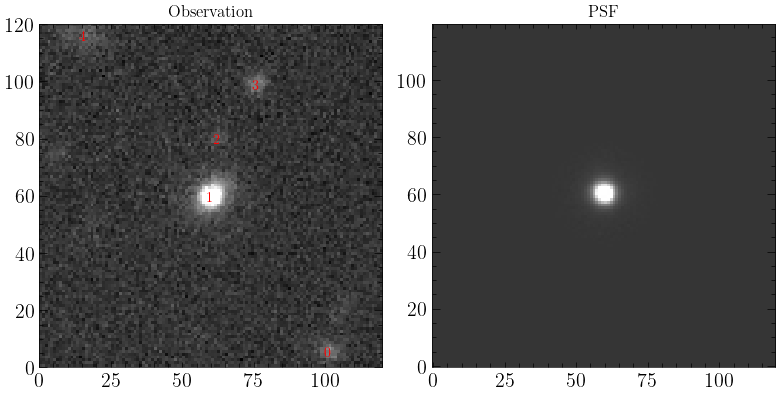

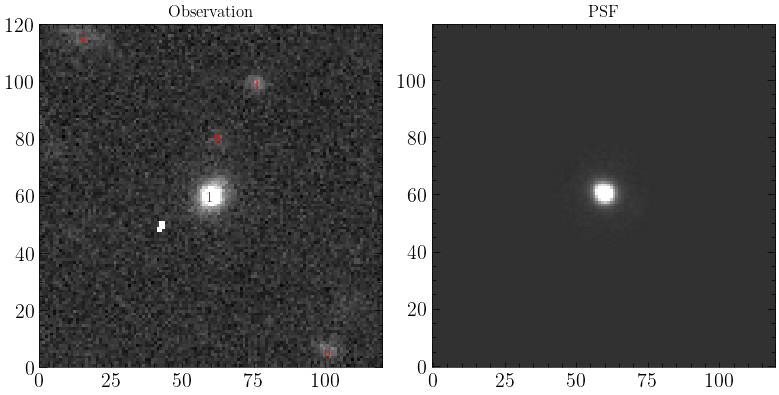

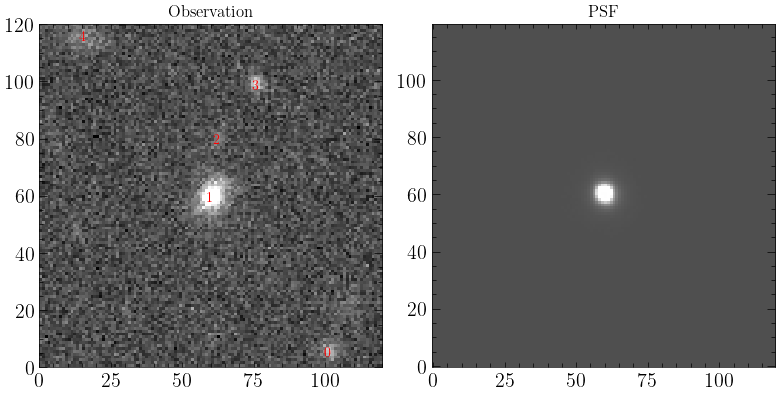

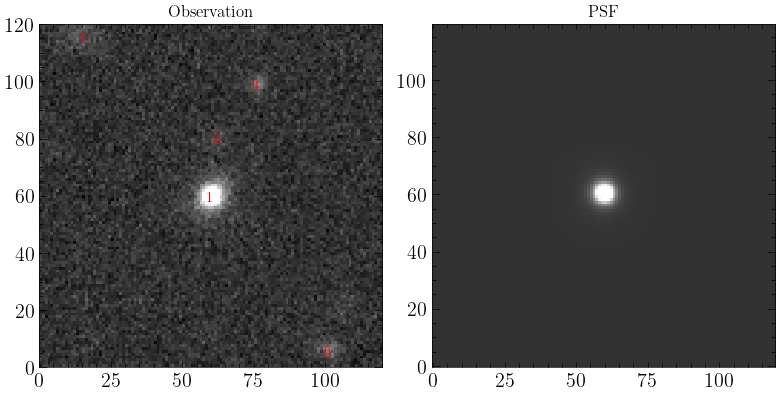

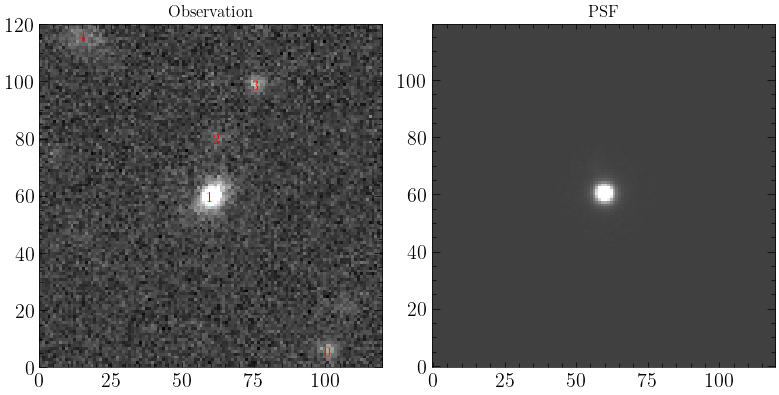

In [20]:
print(np.asarray(ra_dec).shape)
if np.asarray(ra_dec).shape==(2,):
    for ind,(obs, norm) in enumerate(zip(observations[:5], normsingle[:5])):
        scarlet.display.show_observation(obs, norm=norm, sky_coords=[ra_dec], show_psf=True)
else:    
    for ind,(obs, norm) in enumerate(zip(observations[:5], normsingle[:5])):
        scarlet.display.show_observation(obs, norm=norm, sky_coords=ra_dec, show_psf=True)
    

Create the PSF model and create the model frame based on the observations

Define the scarlet2 PSF model and model frame. Match the model frame to the observations.

In [21]:
frame_psf_sc2 = scarlet2.GaussianPSF(0.7)
model_frame_sc2 = scarlet2.Frame(scarlet2.Box((len(observations_sc2),observations_sc2[0].data.shape[-2],observations_sc2[0].data.shape[-1])), psf=frame_psf_sc2, channels=channels_sc2, wcs=wcs_hsc)
for obs in observations_sc2:
    obs.match(model_frame_sc2)

Initialize the scarlet2 morphologies based on scarlet1:

In [22]:
from galaxygrad import HSC_ScoreNet32
print(indtransient)
stepnum=2000
gal_step = 2e-3
AGN_step = 2e-3
from scarlet2 import nn
model_size = 32
count = 0
prior = nn.ScorePrior(
            model=HSC_ScoreNet32
        )
ra_dec = np.asarray(ra_dec)
print(ra_dec[0])
with scarlet2.Scene(model_frame_sc2) as scene:
    for i,pos in enumerate(ra_dec):      
        coord = SkyCoord(pos[0],pos[1],unit="deg")
        pospix = np.asfarray(observations_sc2_init[0].frame.wcs.world_to_pixel(coord))
        center = jnp.asarray(np.asfarray([pos[0],pos[1]]))
        centerpix = jnp.asarray([pospix[1],pospix[0]])
        print('CENTER',center,centerpix)
        if i==indtransient:    
            flux = np.asarray(initialization.pixel_spectrum(observations_sc2, center))[:,0]
            flux = jnp.asarray(flux)
           
            n_steps, peak_value2 = stepnum, jnp.max(flux[~np.isinf(flux)])

            schedule3 = optax.cosine_onecycle_schedule(n_steps, peak_value2, final_div_factor=1)
            AGN_step = lambda p: scarlet2.relative_step(p, factor=5e-4)
            test_step_agn =1e-3*peak_value2
            
            scarlet2.PointSource(
                    centerpix,
                    scarlet2.ArraySpectrum(jnp.asarray(flux)))#, stepsize=AGN_step, constraint=constraints.positive), epochs = channels_zeroed)#,constraint = scarlet2.PositiveConstraint())
                
            print('Making host galaxy')
            flux = 8*np.asarray(initialization.pixel_spectrum(observations_sc2, center))[:,0][inds0]
            
            sersic = scarlet2.SersicMorphology(
                                        center = jnp.asarray(np.asfarray(centerpix)),  
                                        ellipticity = jnp.asarray([0.1,0.1]),
                                        size= jnp.asarray(4.0),
                                        n=jnp.asarray(2.5),
                        )
            scarlet2.Source(
                centerpix,
                scarlet2.StaticArraySpectrum(jnp.asarray(flux),filters=bandall) ,sersic)
           
        else:
            
            print('Making other galaxy')
            flux = jnp.asarray(np.asarray(initialization.pixel_spectrum(observations_sc2, center))[:,0][inds0])
            try:
                morph_init = initialization.adaptive_gaussian_morph(observations_sc2[0], center)
            except ValueError:
                print('Initializing as point source')
                morph_init = np.pad(observations_sc2[0].frame.psf()[0,:,:]-np.min(observations_sc2[0].frame.psf()),(5, 5), 'edge')
            morph_init = morph_init/np.sum(morph_init)+1e-12

            morph_init = jnp.asarray(morph_init)

            scarlet2.Source(
                centerpix,
                scarlet2.StaticArraySpectrum(jnp.asarray(flux),filters=bandall),
                scarlet2.ArrayMorphology(morph_init))
            
step = lambda p: scarlet2.relative_step(p, factor=5e-4)
parameters = scene.make_parameters()
for i in range(len(scene.sources)):
    if i==indtransient:
        parameters += Parameter(scene.sources[i].spectrum.data, name=f"spectrum.{i}", constraint=constraints.positive, stepsize=step)
        parameters += Parameter(scene.sources[i].morphology.center, name=f"spectrum.{i}", constraint=constraints.positive, stepsize=step)
    elif i==indtransient+1:
        parameters += Parameter(scene.sources[i].spectrum.data, name=f"spectrum.{i}", constraint=constraints.positive, stepsize=step)
        parameters += Parameter(scene.sources[i].morphology.center, name=f"morph.{i}", constraint=constraints.positive, stepsize=step)
        parameters += Parameter(scene.sources[i].morphology.ellipticity, name=f"morph.{i}", constraint=constraints.interval(0,1), stepsize=step)
        parameters += Parameter(scene.sources[i].morphology.size, name=f"morph.{i}", constraint=constraints.interval(1.0,15), stepsize=step)
        parameters += Parameter(scene.sources[i].morphology.n, name=f"morph.{i}", constraint=constraints.interval(.5,10), stepsize=step)
    else:
        parameters += Parameter(scene.sources[i].spectrum.data, name=f"spectrum.{i}", constraint=constraints.positive, stepsize=step)
        parameters += Parameter(scene.sources[i].morphology.data, name=f"morph.{i}", constraint=constraints.positive, stepsize=step)
        
scene.set_spectra_to_match(observations_sc2,parameters)

1
[149.73574238   2.06268183]
CENTER [149.73575    2.062682] [  5.2585588 100.75968  ]
Making other galaxy
Zero or negative spectrum in all channels: Setting spectrum to 1
Zero or negative spectrum [-0.00358297] at [149.73575    2.062682]
Zero or negative spectrum in all channels: Setting spectrum to 1
Zero or negative spectrum [-0.119903] at [149.73575    2.062682]
CENTER [149.73766     2.0651984] [59.174667 59.827526]
Making host galaxy
CENTER [149.73755    2.066146] [79.48161  61.991467]
Making other galaxy
Zero or negative spectrum in all channels: Setting spectrum to 1
Zero or negative spectrum [-0.01895678] at [149.73755    2.066146]
Zero or negative spectrum in all channels: Setting spectrum to 1
Zero or negative spectrum [-0.04310026] at [149.73755    2.066146]
Zero or negative spectrum in all channels: Setting spectrum to 1
Zero or negative spectrum [-0.08200269] at [149.73755    2.066146]
Zero or negative spectrum in all channels: Setting spectrum to 1
Zero or negative spectr

Plot scarlet2 initializations

SAVED /scratch/gpfs/cw1074/HSCdata2/plots/505243/505243_modelinitexample.pdf


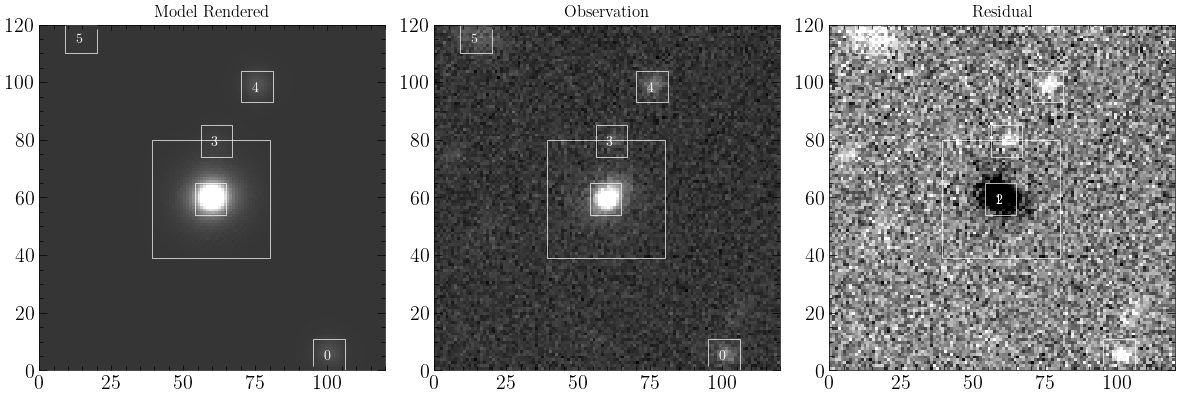

<Figure size 600x450 with 0 Axes>

In [23]:
scarlet2.plot.scene(
    scene,
    observation=np.asarray(observations_sc2)[0],
    norm=np.asarray(normsingle)[0],
    channel_map=None,#np.asarray(channels_sc2[:1]),#[:1],#inds0],
    show_model=False,
    show_observed=True,
    show_rendered=True,
    show_residual=True,
    add_labels=True,
    add_boxes=True,
    linear=True,
)
plt.savefig(plotdir+'/'+srcname+'_modelinitexample.pdf')
print('SAVED',plotdir+'/'+srcname+'_modelinitexample.pdf')
plt.show()
plt.clf()

In [24]:
#Free up the AGN position parameter so that it can be refitted
n_steps, peak_value_pos = stepnum, 1
schedulepos = optax.cosine_onecycle_schedule(n_steps, peak_value_pos, final_div_factor=1)

#Fit the scene
scene_ = scene.fit(observations_sc2, parameters,max_iter=stepnum, e_rel=1e-6, schedule=schedulepos)

  0%|          | 0/2000 [00:00<?, ?it/s]2024-09-22 19:14:13.027986: E external/xla/xla/service/slow_operation_alarm.cc:133] The operation took 6m29.733802377s

********************************
[Compiling module jit__make_step] Very slow compile? If you want to file a bug, run with envvar XLA_FLAGS=--xla_dump_to=/tmp/foo and attach the results.
********************************
  0%|          | 1/2000 [06:57<231:56:03, 417.69s/it, loss=400733792.00, max_change=0.000294]2024-09-22 19:16:40.619654: E external/xla/xla/service/slow_operation_alarm.cc:65] 
********************************
[Compiling module jit__make_step] Very slow compile? If you want to file a bug, run with envvar XLA_FLAGS=--xla_dump_to=/tmp/foo and attach the results.
********************************
2024-09-22 19:21:04.954985: E external/xla/xla/service/slow_operation_alarm.cc:133] The operation took 6m24.335426847s

********************************
[Compiling module jit__make_step] Very slow compile? If you want to file

SAVED /scratch/gpfs/cw1074/HSCdata2/plots/505243/505243_modelexample.pdf


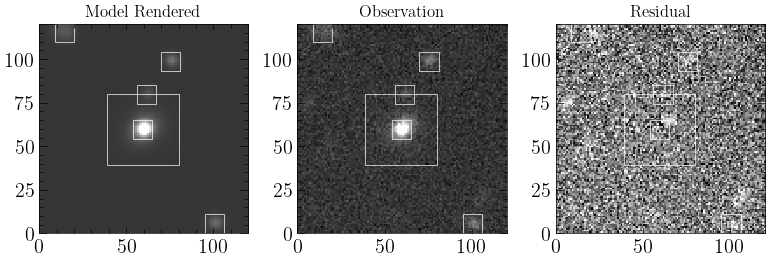

<Figure size 600x450 with 0 Axes>

In [25]:
scarlet2.plot.scene(
    scene_,
    observation=np.asarray(observations_sc2)[0],
    norm=np.asarray(normsingle)[0],
    channel_map=None,
    show_model=False,
    show_observed=True,
    show_rendered=True,
    show_residual=True,
    add_labels=False,
    add_boxes=True,
    linear=True,
    fig_kwargs={'figsize':(7.9,2.9)}
)
plt.savefig(plotdir+'/'+srcname+'_modelexample.pdf')
print('SAVED',plotdir+'/'+srcname+'_modelexample.pdf')
plt.show()
plt.clf()

In [26]:
makequicklc=False
if makequicklc==True:
    fac = np.sum(scene_.sources[indtransient].morphology(),axis=(-2,-1))

    times=np.asarray(times)
    nbin=10
    bandall=['G','I','R','Y','Z']
    flux = scene_.sources[indtransient].spectrum.data
    for bind,(b,c) in enumerate(zip(bandall,['green','orange','red','purple','blue'])):
        try:
            hist,bin_edges=np.histogram(times[epochs==b],bins=int((np.max(times[epochs==b])-np.min(times[epochs==b]))/nbin))
        except:
            continue
        binsize=bin_edges[1]-bin_edges[0]

        binned = np.asarray([np.median(flux[epochs==b][(times[epochs==b]>bin_edges[j]) & (times[epochs==b]<bin_edges[j+1])]) for j in range(len(bin_edges)-1)])
        nonzero = np.argwhere(~np.isnan(binned))[:,0]
        #bin_edges = bin_edges[nonzero]
        binned_error = np.asarray([np.std(np.asarray(flux[epochs==b][(times[epochs==b]>bin_edges[j]) & (times[epochs==b]<bin_edges[j]+binsize)])) for j in nonzero])
        binned_error = np.clip(binned_error,a_min=3*bgsingle[bind],a_max=100)
        binned = binned[nonzero]
        mags = 25-np.log10(binned)
        plt.errorbar(bin_edges[nonzero][mags<27]+binsize-57700,mags[mags<27],yerr=1.0857*binned_error[mags<27]/binned[mags<27],label=b,color=c,marker='.',linestyle='')
        plt.xlabel('MJD-57700')

    plt.ylabel('Magnitude')
    plt.legend(frameon=True)
    plt.gca().invert_yaxis()

    plt.savefig(plotdir+'/'+srcname+'_lc_flux.pdf')
    plt.xlim((0,250))
    print('SAVED',plotdir+'/'+srcname+'_lc_flux_zoom.pdf')
    plt.savefig(plotdir+'/'+srcname+'_lc_flux_zoom.pdf')
    plt.show()

[4754, 7711, 6175, 9762, 8898]


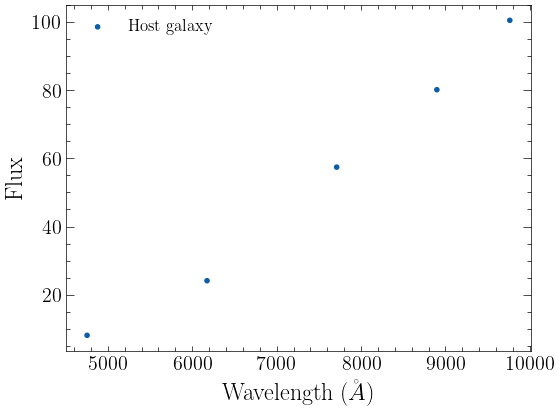

<Figure size 600x450 with 0 Axes>

In [29]:
from numpyro.infer.initialization import init_to_sample
getquickgalaxySED=True
dosampling=False
plotlc=False
wave=waveselect
print(waveselect)
if getquickgalaxySED==True:   
    out = np.column_stack((wave,scene_.sources[indtransient+1].spectrum.data))
    np.savetxt(plotdir+'/sed_quick_updated.txt',np.asarray(out,dtype=str),fmt='%s')
    #fac = np.sum(scene_.sources[indtransient+1].morphology.data,axis=(-2,-1))
    fac=1
    plt.scatter(wave,fac*scene_.sources[indtransient+1].spectrum.data,marker='.',linestyle='',label='Host galaxy')
    plt.xlabel('Wavelength ($\AA$)')
    plt.ylabel('Flux')
    plt.legend()
    plt.savefig(plotdir+'/'+srcname+'_SED_GAL_quick.png')
    plt.show()
    plt.clf()
    
if dosampling==True:
    parameters = scene_.make_parameters()
    p = scene_.sources[indtransient+1].morphology.center
    prior = dist.Normal(p, scale=0.1)
    #parameters += Parameter(p, name=f"morphology.center:"+str(indtransient+1), prior=prior)
    p = scene_.sources[indtransient+1].morphology.ellipticity
    prior = dist.Normal(p, scale=0.1)
    #parameters += Parameter(p, name=f"morphology.ellipticity:"+str(indtransient+1), prior=dist.Normal(p, scale=0.5))
    p = scene_.sources[indtransient+1].morphology.size
    prior = dist.Normal(p, scale=0.1)
    #parameters += Parameter(p, name=f"morphology.size:"+str(indtransient+1), prior=dist.Normal(p, scale=1.0))
    p = scene_.sources[indtransient+1].morphology.n
    prior = dist.Normal(p, scale=0.1)
    parameters += Parameter(p, name=f"morphology.n:"+str(indtransient+1), prior=dist.Normal(p, scale=0.5))
    p = scene_.sources[indtransient+1].spectrum.data
    prior = dist.Normal(p, scale=0.1)
    parameters += Parameter(p, name=f"spectrum:"+str(indtransient+1), prior=prior)
    p = scene_.sources[indtransient].spectrum.data
    prior = dist.Normal(p, scale=0.1)
    parameters += Parameter(p, name=f"spectrum:"+str(indtransient), prior=prior)
    p = scene_.sources[indtransient].morphology.center
    prior = dist.Normal(p, scale=0.1)
    #parameters += Parameter(p, name=f"morphology.center:"+str(indtransient), prior=prior)
 
    mcmc = scene_.sample(observations_sc2,parameters,num_warmup=10, num_samples=20, dense_mass=True, init_strategy=init_to_sample) 
    
    #Get point source position and uncertainties
    '''
    q = mcmc.get_samples()["morphology.center:"+str(indtransient)] 
    q1 = np.percentile(q,[2.5,16,50,84,97.5],axis=0) 
    centerAGN = np.asfarray([q1[2,0],q1[2,1]])
    errorAGN = np.asarray([np.abs(q1[3,0]-q1[1,0]),np.abs(q1[3,1]-q1[1,1])])
    '''
    #Get host galaxy spectrum and uncertainties
    q = mcmc.get_samples()['spectrum:'+str(indtransient+1)] 
    q1 = np.percentile(q,[2.5,16,50,84,97.5],axis=0)
    fac = np.sum(scene_.sources[indtransient+1].morphology(),axis=(-2,-1))
    galfluxes = []
    galfluxerrors = []
    for i,b in zip(range(q1.shape[1]),inds0):
        print(i,'median = ',q1[2][i],'std = ',(q1[3][i]-q1[1][i])/2)
        galfluxes.append(q1[2][i]*fac)
        galfluxerrors.append((q1[3][i]-q1[1][i])/2*fac)
    mcmc.print_summary()
    #corner.corner(mcmc).show()
    #plt.savefig(plotdir+'/'+srcname+'_galflux_corner.png')
    plt.show()
    plt.clf()
    sedgal = np.asfarray(galfluxes)
    sedgalerr = np.asfarray(galfluxerrors)
    plt.errorbar(wave,22.5-np.log10(sedgal),yerr= 1.0857* sedgalerr/sedgal,marker='.',linestyle='',label='Host galaxy')
    plt.xlabel('Wavelength ($\AA$)')
    plt.ylabel('Flux')
    plt.legend()
    plt.gca().invert_yaxis()
    plt.savefig(plotdir+'/'+srcname+'_SED_GAL.png')
    plt.show()
    plt.clf()
    outsedhead=['WAVE_CEN','GALFLUX','GALFLUXERR']
    outsed=np.column_stack((wave,sedgal,sedgalerr))
    outsed = np.vstack((outsedhead,outsed))
    print(outsed)
    np.savetxt(plotdir+'/sedgal_updated.txt',np.asarray(outsed,dtype=str),fmt='%s')
    print('Saved',plotdir+'/sedgal_updated.txt')

if plotlc==True:
    #Get transient light curve 
    q = mcmc.get_samples()['spectrum:'+str(indtransient)]
    q1 = np.percentile(q,[2.5,16,50,84,97.5],axis=0) 
    fac = np.sum(scene_.sources[indtransient].morphology(),axis=(-2,-1)) 
    fluxes = [] 
    fluxerrors = [] 
    for i in range(q1.shape[1]): 
        print(i,'median = ',q1[2][i],'std = ',(q1[3][i]-q1[1][i])/2) 
        fluxes.append(q1[2][i]*fac) 
        fluxerrors.append((q1[3][i]-q1[1][i])/2*fac)

    mcmc.print_summary() 

    zps = np.asfarray(zps)
    fluxes = np.asfarray(fluxes)
    fluxerrors = np.asfarray(fluxerrors) 
    times=np.asfarray(times)
    fac = np.sum(scene_.sources[indtransient].morphology(),axis=(-2,-1))
    
    for bind,(b,c) in enumerate(zip(bandall,['green','orange','red','purple','blue'])):
        plt.errorbar(times[epochs==b]-57700,fluxes[epochs==b],yerr = fluxerrors[epochs==b],linestyle='',label=b,color=c,marker='.')#+fluxgal[epochs==b]),label=b,color=c,marker='.')
    plt.xlabel('MJD-57700')
    plt.xlim((0,300))
    #plt.ylim((22.0,22.3))
    plt.ylabel('Flux')
    plt.legend()
    plt.title(srcname)
    plt.savefig(plotdir+'/'+srcname+'_lc_flux.png')
    plt.show()
    plt.clf()
    outlchead=['MJD','FLUX','FLUXERR','BAND']
    outlc=np.column_stack((times,fluxes,fluxerrors,epochs))
    outlc = np.vstack((outlchead,outlc))
    np.savetxt(plotdir+'/lc.txt',np.asarray(outlc,dtype=str),fmt='%s')
    sed=[]
    sederr=[]
    for b,c in zip(bandall,['green','orange','red','purple','blue']):
        sed.append(np.mean(fluxes[epochs==b]))
        sederr.append(np.std(fluxes[epochs==b]))
        plt.errorbar(times[epochs==b]-57700,25-2.5*np.log10(fluxes[epochs==b]),yerr = 1.0857*fluxerrors[epochs==b]/fluxes[epochs==b],linestyle='',label=b,color=c,marker='.')#+fluxgal[epochs==b]),label=b,color=c,marker='.')
    plt.xlabel('MJD-57700')
    plt.xlim((0,300))
    #plt.ylim((22.0,22.3))
    plt.ylabel('Magnitude')
    plt.gca().invert_yaxis()
    plt.legend()
    plt.savefig(plotdir+'/'+srcname+'_lc_mag.png')
    plt.show()

## 